# MathTool HW4
2024-11-13

## Question 3

### a)

In [1]:
import numpy as np
import scipy.io
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [2]:
mat = scipy.io.loadmat('experimentData.mat')
data = mat['data']  # N x 3 matrix
trialConds = mat['trialConds'].flatten()  # N x 1 vector

In [3]:
unique_conditions, counts = np.unique(trialConds, return_counts=True)
condition_counts = {int(cond): int(count) for cond, count in zip(unique_conditions, counts)}
print("Condition Counts:", condition_counts)

Condition Counts: {1: 300, 2: 312}


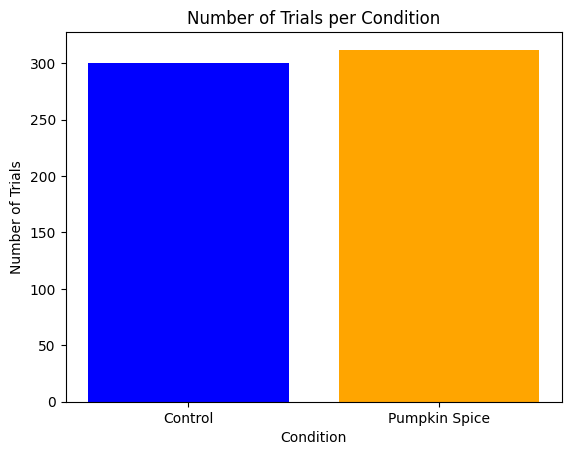

In [4]:
# Histogram for each conditons
plt.figure()
plt.bar(['Control', 'Pumpkin Spice'], counts, color=['blue', 'orange'])
plt.xlabel("Condition")
plt.ylabel("Number of Trials")
plt.title("Number of Trials per Condition")
plt.show()

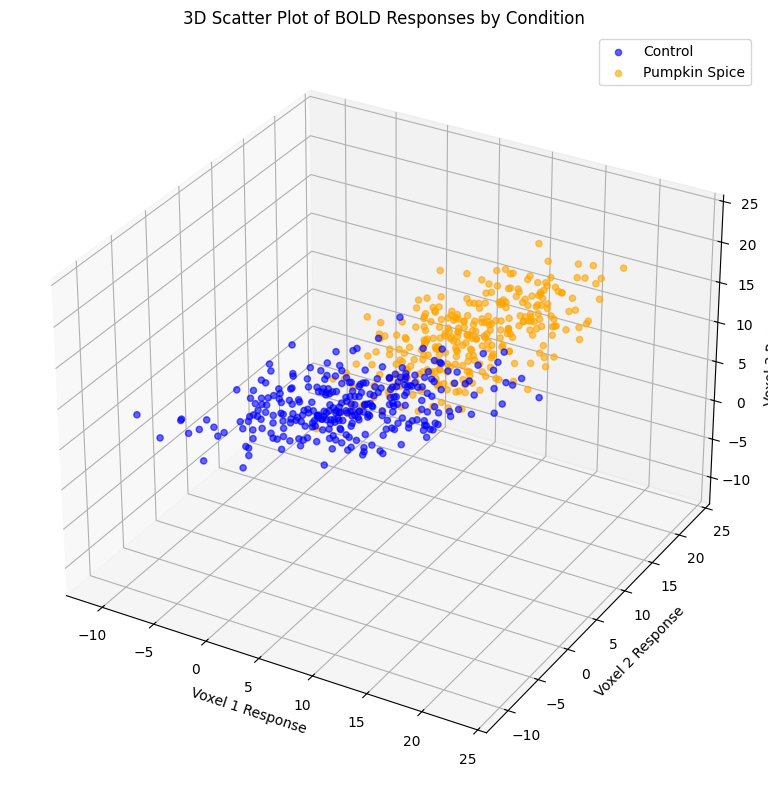

In [5]:
# 3D scatter plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

control_data = data[trialConds == 1]
pumpkin_spice_data = data[trialConds == 2]

# Control condition
ax.scatter(control_data[:, 0], control_data[:, 1], control_data[:, 2], 
           color='blue', label='Control', alpha=0.6)

# Pumpkin spice
ax.scatter(pumpkin_spice_data[:, 0], pumpkin_spice_data[:, 1], pumpkin_spice_data[:, 2], 
           color='orange', label='Pumpkin Spice', alpha=0.6)

x_min, x_max = data[:, 0].min(), data[:, 0].max()
y_min, y_max = data[:, 1].min(), data[:, 1].max()
z_min, z_max = data[:, 2].min(), data[:, 2].max()
overall_min = min(x_min, y_min, z_min)
overall_max = max(x_max, y_max, z_max)

ax.set_xlim([overall_min, overall_max])
ax.set_ylim([overall_min, overall_max])
ax.set_zlim([overall_min, overall_max]) 

ax.set_xlabel("Voxel 1 Response")
ax.set_ylabel("Voxel 2 Response")
ax.set_zlabel("Voxel 3 Response")
ax.set_title("3D Scatter Plot of BOLD Responses by Condition")
ax.legend()

plt.tight_layout()
plt.show()

To describe them qualitatively, Control and Pumpkin Spice conditions show distinct and separable response patterns in the 3D voxel response space. The Control condition is more tightly clustered with lower response values, while the Pumpkin Spice condition has higher and more variable responses across the voxel dimensions. These patterns suggest that each condition evokes a unique activation pattern in the amygdala, with the Pumpkin Spice condition leading to broader and higher-range voxel responses.

There is a noticeable difference between these two conditions.
Control conditions (in blue) is more clustered around lower values across all three voxel response dimensions. Whereas the pumpkin spice condition (in orange) is more clustered around higher value, which means that there are higher BOLD responses in these voxels when the pumpkin spice odorant is presented to customers. 

The shape of the response cloud is in **an ellipsoidal shape in 3D space**, because of the elongation along their axis.

I would use a **multivariate Gaussian distribution** to describe the data. Since it can capture the mean response and the covariance structure (spread) for each conditions, as well as refelcting their correlations to the voxel responses. Since in the data, they form an elliptical-shaped cluster and they appear to have some directionality. Also, with distinct means, correlations between voxel responses, and gradual variability. Those characteristics align well with properties of multivariate Gaussian. 


### b)

In [6]:
# calculate the mean
control_mean = np.mean(control_data, axis=0)
pumpkin_mean = np.mean(pumpkin_spice_data, axis=0)

print("Control Condition Mean:", control_mean)
print("Pumpkin Spice Condition Mean:", pumpkin_mean)

Control Condition Mean: [2.97707955 4.24881879 4.97436515]
Pumpkin Spice Condition Mean: [ 9.98186089 12.08375561 11.07413275]


In [7]:
# center the data
centered_control_data = control_data - control_mean
centered_pumpkin_spice_data = pumpkin_spice_data - pumpkin_mean

In [8]:
# covariance matrix
def get_covariance_matrix(data_in):
    N,M = data_in.shape
    covariance_matrix = np.zeros((M, M))
    for i in range(M):
        for j in range(M):
            covariance_matrix[i, j] = np.sum(data_in[:, i] * data_in[:, j]) / (N - 1)
    return covariance_matrix

control_cov_manual = get_covariance_matrix(centered_control_data)
pumpkin_cov_manual = get_covariance_matrix(centered_pumpkin_spice_data)

print("\nControl Condition Covariance Matrix (Manual):\n", control_cov_manual)
print("Pumpkin Spice Condition Covariance Matrix (Manual):\n", pumpkin_cov_manual)

# Sanity check
control_cov_manual_py = np.dot(centered_control_data.T, centered_control_data) / (centered_control_data.shape[0] - 1)
pumpkin_cov_manual_py = np.dot(centered_pumpkin_spice_data.T, centered_pumpkin_spice_data) / (centered_pumpkin_spice_data.shape[0] - 1)

print("\nControl Condition Covariance Matrix (Python):\n", control_cov_manual_py)
print("Pumpkin Spice Condition Covariance Matrix (Python):\n", pumpkin_cov_manual_py)


Control Condition Covariance Matrix (Manual):
 [[26.13151392  9.8203437   4.90869037]
 [ 9.8203437  15.74570991  3.40750737]
 [ 4.90869037  3.40750737  3.3829186 ]]
Pumpkin Spice Condition Covariance Matrix (Manual):
 [[12.90381388  8.09733134  2.91064268]
 [ 8.09733134 26.94541895  6.31922585]
 [ 2.91064268  6.31922585  4.42510768]]

Control Condition Covariance Matrix (Python):
 [[26.13151392  9.8203437   4.90869037]
 [ 9.8203437  15.74570991  3.40750737]
 [ 4.90869037  3.40750737  3.3829186 ]]
Pumpkin Spice Condition Covariance Matrix (Python):
 [[12.90381388  8.09733134  2.91064268]
 [ 8.09733134 26.94541895  6.31922585]
 [ 2.91064268  6.31922585  4.42510768]]


In [9]:
# convolution
control_cov_np = np.cov(control_data, rowvar=False)
pumpkin_cov_np = np.cov(pumpkin_spice_data, rowvar=False)

print("No difference in Control Condition Covariance Matrices? :", np.allclose(control_cov_manual, control_cov_np))
print("No cifference in Pumpkin Spice Condition Covariance Matrices? :", np.allclose(pumpkin_cov_manual, pumpkin_cov_np))

No difference in Control Condition Covariance Matrices? : True
No cifference in Pumpkin Spice Condition Covariance Matrices? : True


In the covariance matrix:
 the diagonal element represents the **variance** of each voxel's response for each condition.
 the off-diagnoal elements represents the **covariance** between voxel responses. 

Firstly, comparing the variances we can say that:
1. voxel 1 is showing higher variability in control condition comparing to pumpkin spice condition;
2. voxel 2 is showing higher variability in pumpkin spice condition compared to control condition;
3. voxel 3 is not exhibiting that much differences in variability comparing between two conditions.
Overall, it's showing that activities in voxels are varying differently under these two conditions.

Secondly, comparing the covariance we can say that:
1. the correlation between voxel 1 and voxel 2 is stronger in control condition than in pumpkin spice condition;
2. the correlation between voxel 2 and voxel 3 is stronger in pumpkin spice condition than in control condition.
So overall, the pattern of correlations between voxels changes according to conditions. 

In all, we can say that the physiological responses pattern is different based on conditions.



### c)

In [10]:
# svd
U_control, S_control, Vt_control = np.linalg.svd(control_cov_manual)
U_pumpkin, S_pumpkin, Vt_pumpkin = np.linalg.svd(pumpkin_cov_manual)

In [11]:
# scale their amplitude by the square root of the singular value
control_singular_vectors = U_control * np.sqrt(S_control)
pumpkin_singular_vectors = U_pumpkin * np.sqrt(S_pumpkin)

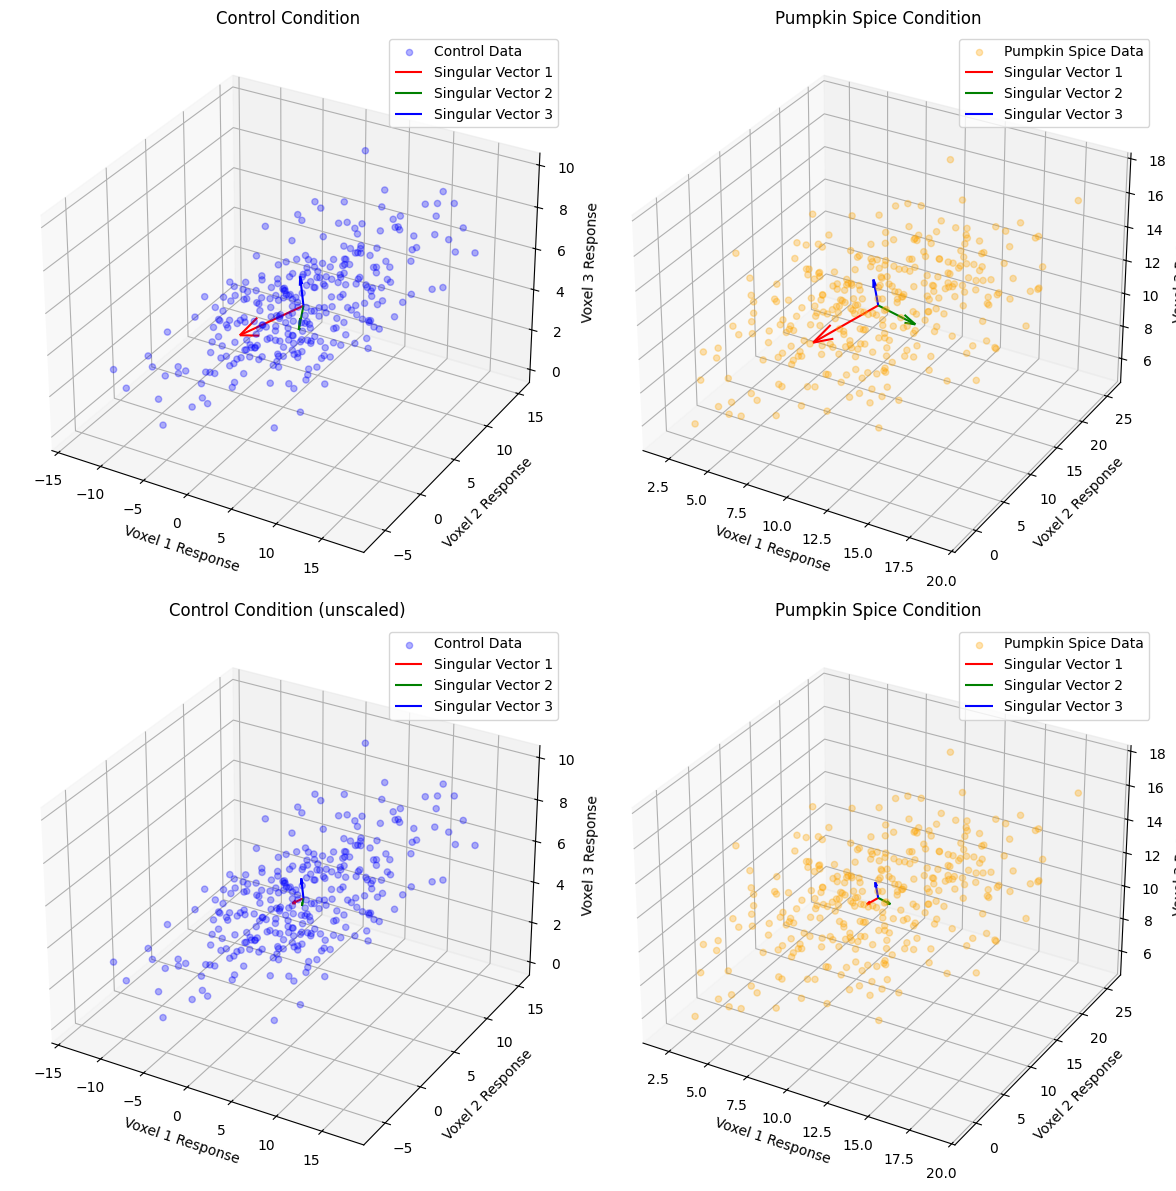

In [12]:
fig = plt.figure(figsize=(12, 12))

#Plotting the scaled verison
# control condition
ax1 = fig.add_subplot(221, projection='3d')
ax1.scatter(control_data[:, 0], control_data[:, 1], control_data[:, 2], color='blue', alpha=0.3, label='Control Data')

ax1.quiver(control_mean[0], control_mean[1], control_mean[2], 
           control_singular_vectors[0, 0], control_singular_vectors[1, 0], control_singular_vectors[2, 0], color='r', label='Singular Vector 1')
ax1.quiver(control_mean[0], control_mean[1], control_mean[2], 
           control_singular_vectors[0, 1], control_singular_vectors[1, 1], control_singular_vectors[2, 1], color='g', label='Singular Vector 2')
ax1.quiver(control_mean[0], control_mean[1], control_mean[2], 
           control_singular_vectors[0, 2], control_singular_vectors[1, 2], control_singular_vectors[2, 2], color='b', label='Singular Vector 3')

ax1.set_title('Control Condition')
ax1.set_xlabel('Voxel 1 Response')
ax1.set_ylabel('Voxel 2 Response')
ax1.set_zlabel('Voxel 3 Response')
ax1.legend()

# ps condition
ax2 = fig.add_subplot(222, projection='3d')
ax2.scatter(pumpkin_spice_data[:, 0], pumpkin_spice_data[:, 1], pumpkin_spice_data[:, 2], color='orange', alpha=0.3, label='Pumpkin Spice Data')

ax2.quiver(pumpkin_mean[0], pumpkin_mean[1], pumpkin_mean[2], 
           pumpkin_singular_vectors[0, 0], pumpkin_singular_vectors[1, 0], pumpkin_singular_vectors[2, 0], color='r', label='Singular Vector 1')
ax2.quiver(pumpkin_mean[0], pumpkin_mean[1], pumpkin_mean[2], 
           pumpkin_singular_vectors[0, 1], pumpkin_singular_vectors[1, 1], pumpkin_singular_vectors[2, 1], color='g', label='Singular Vector 2')
ax2.quiver(pumpkin_mean[0], pumpkin_mean[1], pumpkin_mean[2], 
           pumpkin_singular_vectors[0, 2], pumpkin_singular_vectors[1, 2], pumpkin_singular_vectors[2, 2], color='b', label='Singular Vector 3')

ax2.set_title('Pumpkin Spice Condition')
ax2.set_xlabel('Voxel 1 Response')
ax2.set_ylabel('Voxel 2 Response')
ax2.set_zlabel('Voxel 3 Response')
ax2.legend()

#Plotting the un-scaled verison
ax3 = fig.add_subplot(223, projection='3d')
ax3.scatter(control_data[:, 0], control_data[:, 1], control_data[:, 2], color='blue', alpha=0.3, label='Control Data')

ax3.quiver(control_mean[0], control_mean[1], control_mean[2], 
           U_control[0, 0], U_control[1, 0], U_control[2, 0], color='r', label='Singular Vector 1')
ax3.quiver(control_mean[0], control_mean[1], control_mean[2], 
           U_control[0, 1], U_control[1, 1], U_control[2, 1], color='g', label='Singular Vector 2')
ax3.quiver(control_mean[0], control_mean[1], control_mean[2], 
           U_control[0, 2], U_control[1, 2], U_control[2, 2], color='b', label='Singular Vector 3')

ax3.set_title('Control Condition (unscaled)')
ax3.set_xlabel('Voxel 1 Response')
ax3.set_ylabel('Voxel 2 Response')
ax3.set_zlabel('Voxel 3 Response')
ax3.legend()

ax4 = fig.add_subplot(224, projection='3d')
ax4.scatter(pumpkin_spice_data[:, 0], pumpkin_spice_data[:, 1], pumpkin_spice_data[:, 2], color='orange', alpha=0.3, label='Pumpkin Spice Data')

ax4.quiver(pumpkin_mean[0], pumpkin_mean[1], pumpkin_mean[2], 
           U_pumpkin[0, 0], U_pumpkin[1, 0], U_pumpkin[2, 0], color='r', label='Singular Vector 1')
ax4.quiver(pumpkin_mean[0], pumpkin_mean[1], pumpkin_mean[2], 
           U_pumpkin[0, 1], U_pumpkin[1, 1], U_pumpkin[2, 1], color='g', label='Singular Vector 2')
ax4.quiver(pumpkin_mean[0], pumpkin_mean[1], pumpkin_mean[2], 
           U_pumpkin[0, 2], U_pumpkin[1, 2], U_pumpkin[2, 2], color='b', label='Singular Vector 3')

ax4.set_title('Pumpkin Spice Condition')
ax4.set_xlabel('Voxel 1 Response')
ax4.set_ylabel('Voxel 2 Response')
ax4.set_zlabel('Voxel 3 Response')
ax4.legend()




plt.tight_layout()
plt.show()

In [13]:
print("Singular values for Control Condition:", S_control)
print("Singular values for Pumpkin Spice Condition:", S_pumpkin)

Singular values for Control Condition: [33.23863988  9.84826949  2.17323307]
Singular values for Pumpkin Spice Condition: [32.37371079  9.20749237  2.69313735]


Singular values in both conditions:
First > second > third, meaning that the primary direction of the variance explain most of the variabilities in data of both conditions. 
The first singular value in both conditions are relatively close, meaning that the variability in their voxel 1 responses are quite similar.
For the seocnd and thir singular values, they are also relatively close, but control condition has more variability in voxel 2 response while the pumpkin spice condition is having more variability in voxel 3. The control condition is having more variance in second principal direction. The pumpkin spice condition is having more variance in the third principle condition.

By doing SVD, it can tell us the overall variancve structure of two sets of data. From calculated value, we can say that although control condition and pumpkin spice conditions' data is varied, but they are in similar spread and similar pattern of voxel activities. So two ordants are eliciting similar activities in amygdala, but given that the second and third values are slightly differed (reflecting variances in voxel activities), we can say that those two ordants may be engaging in different process network wise.

By comparing relationships between three singular values, we can see that the voxel responses are correlated in comparable ways in both conditions. The relationships between voxel responses remain relatively stable, implying a similar (consistent) neural network pathway in amygdala.






### d)

In [14]:
# Data simulation

import numpy as np

def ndRandn(mean, cov, num=1):
    # mean (an N-vector)
    # covariance (an NxN matrix)
    # num should be optional (defaulting to 1) and should specify the number of samples to return

    N_qd = len(mean)

    # generate samples from an N-dimensional Gaussian with zero mean and identity covariance matrix
    standard_samples = np.random.randn(num, N_qd)
    # and then transform these to achieve the desired mean and covariance
    eigvals, eigvecs = np.linalg.eigh(cov)
    transform_matrix = eigvecs @ np.diag(np.sqrt(eigvals))
    transformed_samples = standard_samples @ transform_matrix.T

    samples = transformed_samples + mean

    return samples

In [15]:
mean_test = np.array([3, 5])
cov_test = np.array([[10, -4], [-4, 5]])
num_samples = 1000

In [16]:
samples = ndRandn(mean_test, cov_test, num_samples)
sample_mean = np.mean(samples, axis=0)
sample_cov = np.cov(samples, rowvar=False)

In [17]:
print("Requested Mean:", mean_test)
print("Sample Mean:", sample_mean)
print("\nRequested Covariance:\n", cov_test)
print("Sample Covariance:\n", sample_cov)

Requested Mean: [3 5]
Sample Mean: [2.94518141 5.00561567]

Requested Covariance:
 [[10 -4]
 [-4  5]]
Sample Covariance:
 [[10.3665522  -3.82032791]
 [-3.82032791  4.8542635 ]]


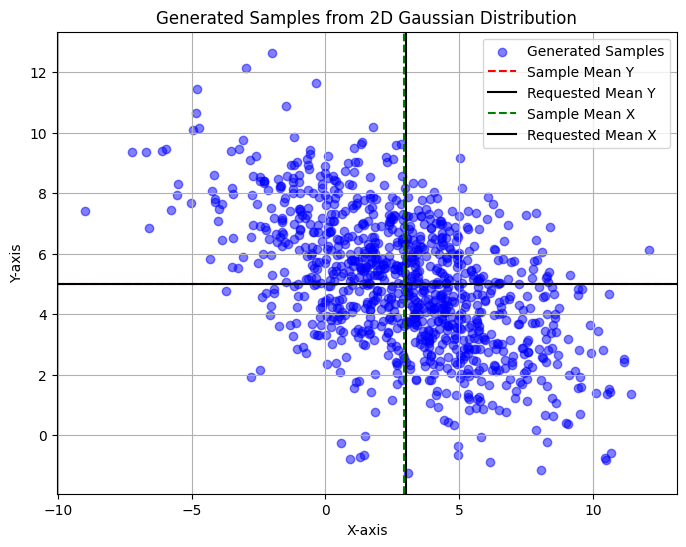

In [18]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.scatter(samples[:, 0], samples[:, 1], color='blue', alpha=0.5, label='Generated Samples')
plt.axhline(y=sample_mean[1], color='red', linestyle='--', label='Sample Mean Y')
plt.axhline(y=mean_test[1], color='black', linestyle='-', label='Requested Mean Y')
plt.axvline(x=sample_mean[0], color='green', linestyle='--', label='Sample Mean X')
plt.axvline(x=mean_test[0], color='black', linestyle='-', label='Requested Mean X')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.title('Generated Samples from 2D Gaussian Distribution')
plt.legend()
plt.grid()
plt.show()

We can see that the sample mean and sample are very close to requested mean and requested covariance. Therefore we can say that the simulation provides a reasonable approximation towards the requested distribution. 

### e)

In [19]:
def odorExperiment(mean_cond1, cov_cond1, numTrials1,mean_cond2, cov_cond2, numTrials2):
    #simResponses (Nx3)
    #N=numTrials1+numTrials2
    responses_cond1 = ndRandn(mean_cond1, cov_cond1, numTrials1)
    responses_cond2 = ndRandn(mean_cond2, cov_cond2, numTrials2)
    simResponses = np.vstack((responses_cond1, responses_cond2))
    return simResponses

In [20]:
numTrials1 = 300
numTrials2 = 312

In [21]:
simResponses = odorExperiment(control_mean, control_cov_manual, numTrials1,pumpkin_mean, pumpkin_cov_manual, numTrials2)

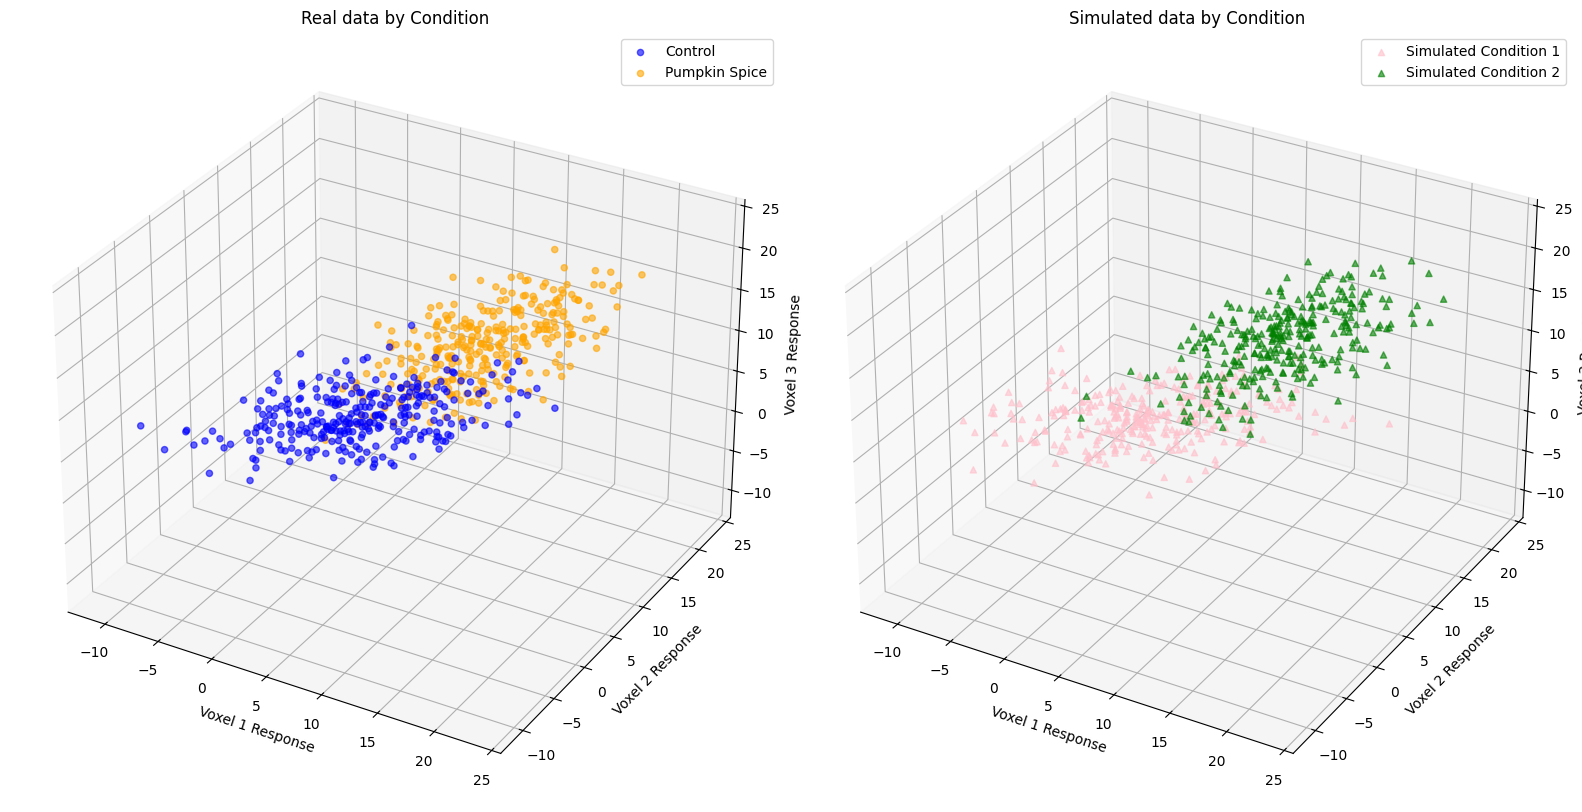

In [22]:
fig = plt.figure(figsize=(16, 8))

#real data
ax1 = fig.add_subplot(121, projection='3d')
ax1.scatter(control_data[:, 0], control_data[:, 1], control_data[:, 2], color='blue', label='Control', alpha=0.6)
ax1.scatter(pumpkin_spice_data[:, 0], pumpkin_spice_data[:, 1], pumpkin_spice_data[:, 2], color='orange', label='Pumpkin Spice', alpha=0.6)

x_min, x_max = data[:, 0].min(), data[:, 0].max()
y_min, y_max = data[:, 1].min(), data[:, 1].max()
z_min, z_max = data[:, 2].min(), data[:, 2].max()
overall_min = min(x_min, y_min, z_min)
overall_max = max(x_max, y_max, z_max)

ax1.set_xlim([overall_min, overall_max])
ax1.set_ylim([overall_min, overall_max])
ax1.set_zlim([overall_min, overall_max])

ax1.set_xlabel("Voxel 1 Response")
ax1.set_ylabel("Voxel 2 Response")
ax1.set_zlabel("Voxel 3 Response")
ax1.set_title("Real data by Condition")
ax1.legend()

#smulated data
ax2 = fig.add_subplot(122, projection='3d')
ax2.scatter(simResponses[:numTrials1, 0], simResponses[:numTrials1, 1], simResponses[:numTrials1, 2], color='pink', marker='^', label='Simulated Condition 1', alpha=0.6)
ax2.scatter(simResponses[numTrials1:, 0], simResponses[numTrials1:, 1], simResponses[numTrials1:, 2], color='green', marker='^', label='Simulated Condition 2', alpha=0.6)

ax2.set_xlim([overall_min, overall_max])
ax2.set_ylim([overall_min, overall_max])
ax2.set_zlim([overall_min, overall_max])

ax2.set_xlabel("Voxel 1 Response")
ax2.set_ylabel("Voxel 2 Response")
ax2.set_zlabel("Voxel 3 Response")
ax2.set_title("Simulated data by Condition")
ax2.legend()

plt.tight_layout()
plt.show()

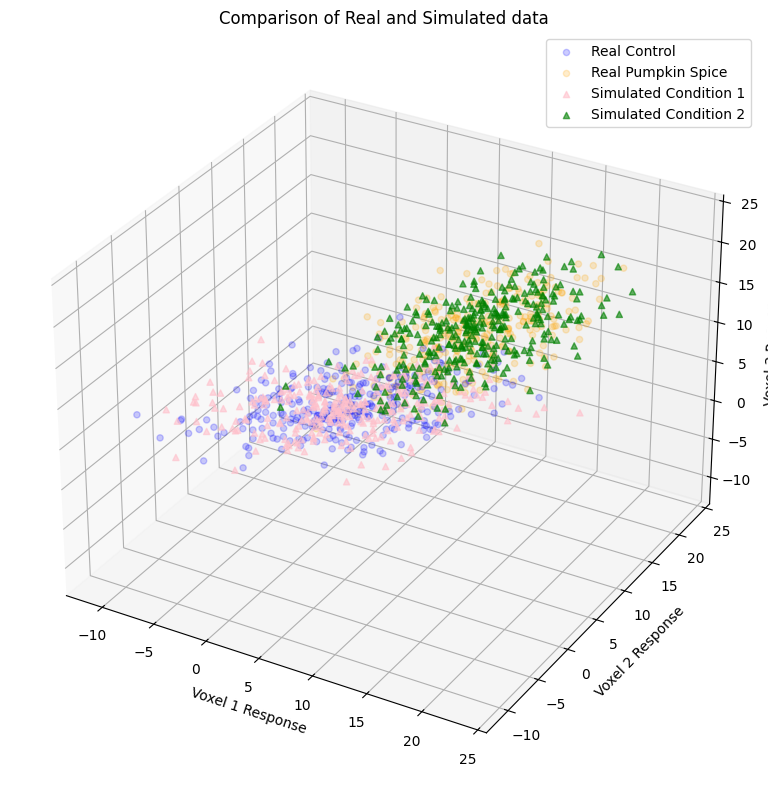

In [23]:
#Plotting against each other
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

#real data
ax.scatter(control_data[:, 0], control_data[:, 1], control_data[:, 2], 
           color='blue', marker='o', label='Real Control', alpha=0.2)
ax.scatter(pumpkin_spice_data[:, 0], pumpkin_spice_data[:, 1], pumpkin_spice_data[:, 2], 
           color='orange', marker='o', label='Real Pumpkin Spice', alpha=0.2)

# simulation
ax.scatter(simResponses[:numTrials1, 0], simResponses[:numTrials1, 1], simResponses[:numTrials1, 2], 
           color='pink', marker='^', label='Simulated Condition 1', alpha=0.6)

ax.scatter(simResponses[numTrials1:, 0], simResponses[numTrials1:, 1], simResponses[numTrials1:, 2], 
           color='green', marker='^', label='Simulated Condition 2', alpha=0.6)

x_min = min(data[:, 0].min(), simResponses[:, 0].min())
x_max = max(data[:, 0].max(), simResponses[:, 0].max())
y_min = min(data[:, 1].min(), simResponses[:, 1].min())
y_max = max(data[:, 1].max(), simResponses[:, 1].max())
z_min = min(data[:, 2].min(), simResponses[:, 2].min())
z_max = max(data[:, 2].max(), simResponses[:, 2].max())
overall_min = min(x_min, y_min, z_min)
overall_max = max(x_max, y_max, z_max)

ax.set_xlim([overall_min, overall_max])
ax.set_ylim([overall_min, overall_max])
ax.set_zlim([overall_min, overall_max])

ax.set_xlabel("Voxel 1 Response")
ax.set_ylabel("Voxel 2 Response")
ax.set_zlabel("Voxel 3 Response")
ax.set_title("Comparison of Real and Simulated data")
ax.legend()

plt.tight_layout()
plt.show()

Yes, our simulated response data is a good characterization of the real voxel responses. Since we are using the Gaussian as the model to generate simulation; if Gaussian is a good model, the simulated results should be characterizing the real data. 